In [1]:
# 절대 임포트 설정
from __future__ import division, print_function, absolute_import

# 필요한 라이브러리들을 임포트
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# MNIST 데이터를 다운로드 한다.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
# 파라미터 설정
learning_rate_RMSProp = 0.01
learning_rate_Gradient_Descent = 0.5
training_epochs = 100     # epoch 횟수 (iteration)
softmax_classifier_iterations = 1000 # Softmax Classifier iteration 횟수 
batch_size = 256          
display_step = 1        # 몇 Step마다 log를 출력할지 결정한다.
examples_to_show = 10   # reconstruct된 이미지 중 몇개를 보여줄지를 결정한다. 
       

param_sparsity=0.01
param_weight_decay=0.0001
param_sparse_panelty=3

## SAE를 순차적으로 실행하는 방식

total_batch  214


Epoch: 0001 cost= 52.024902344
Epoch: 0002 cost= 47.459419250
Epoch: 0003 cost= 45.408912659
Epoch: 0004 cost= 43.357357025
Epoch: 0005 cost= 43.600368500
Epoch: 0006 cost= 41.885299683
Epoch: 0007 cost= 41.919757843
Epoch: 0008 cost= 39.151607513
Epoch: 0009 cost= 38.889816284
Epoch: 0010 cost= 37.727092743
Epoch: 0011 cost= 37.387474060
Epoch: 0012 cost= 35.485176086
Epoch: 0013 cost= 36.108280182
Epoch: 0014 cost= 34.342391968
Epoch: 0015 cost= 34.261070251
Epoch: 0016 cost= 32.857566833
Epoch: 0017 cost= 34.351337433
Epoch: 0018 cost= 33.147644043
Epoch: 0019 cost= 31.848552704
Epoch: 0020 cost= 30.859966278
Epoch: 0021 cost= 30.594980240
Epoch: 0022 cost= 29.485719681
Epoch: 0023 cost= 29.421230316
Epoch: 0024 cost= 28.861782074
Epoch: 0025 cost= 28.633451462
Epoch: 0026 cost= 28.060117722
Epoch: 0027 cost= 28.648927689
Epoch: 0028 cost= 28.505985260
Epoch: 0029 cost= 26.628154755
Epoch: 0030 cost= 26.288959503
Epoch: 0031 cost= 26.388591766
Epoch: 0032 cost= 25.846511841
Epoch: 0

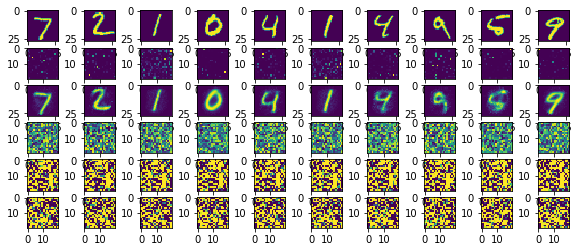

In [8]:
# Stacked Autoencoder를 생성한다.

def regularization(weights):
    return tf.nn.l2_loss(weights)

def Single_Layer_Autoencoder(Input_Layer, n_input, n_hidden):
    with tf.name_scope("Hidden_Layer") as scope:
        # 히든 레이어 1을 위한 Weights와 Biases
        W_ih = tf.Variable(tf.random_normal([n_input, n_hidden]), name = "Weight_IH")  # IH = Input_Hidden
        b_ih = tf.Variable(tf.random_normal([n_hidden]), name = "Bias_IH")
        H_Layer = tf.nn.sigmoid(tf.matmul(Input_Layer, W_ih) + b_ih, name = "Hidden")     # 히든레이어 1의 activation (sigmoid 함수를 사용)
               
    with tf.name_scope("Reconstructed_Layer") as scope:
        # Output 레이어를 위한 Weights와 Biases
        W_hr = tf.Variable(tf.random_normal([n_hidden, n_input]), name = "Weight_HR")  # HR = Hidden_Reconstructed
        b_hr = tf.Variable(tf.random_normal([n_input]), name = "Bias_HR")
        X_reconstructed = tf.nn.sigmoid(tf.matmul(H_Layer,W_hr) + b_hr, name = "Hidden_HR")   # Output 레이어의 activation (sigmoid 함수를 사용)
    
    with tf.name_scope("cost") as scope:        
    # Autoencoder Optimization을 위한 파라미터들
        average_act_hidden = tf.reduce_mean(H_Layer,axis=0)   #Average hidden layer over all data points in X, Page 14 in https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf
        diff = Input_Layer - X_reconstructed
        KL = Kullback_Leibler_divergence(rho, average_act_hidden)
        cost= 0.5*tf.reduce_mean(tf.reduce_sum(tf.pow(diff,2),axis=1)) + 0.5*Lambda*(tf.nn.l2_loss(W_ih) + tf.nn.l2_loss(W_hr)) + Beta*tf.reduce_sum(KL)
        cost_summary = tf.summary.scalar("cost", cost)
        

    return H_Layer, X_reconstructed, cost

def Kullback_Leibler_divergence(rho, rho_hat):
    return rho * tf.log(rho) - rho * tf.log(rho_hat) + (1 - rho) * tf.log(1 - rho) - (1 - rho) * tf.log(1 - rho_hat)

rho = param_sparsity
Lambda = param_weight_decay
Beta = param_sparse_panelty

# 학습에 필요한 변수들 설정
with tf.name_scope("Tensor_initialize"):
    X = tf.placeholder("float", [None, 784], name = "Input")    # Input 데이터 설정
    y_ = tf.placeholder(tf.float32, [None, 10], name = "True_Output")   # True Output

with tf.name_scope("Auto_Encoder_01"):
    H1, O1, cost1 = Single_Layer_Autoencoder(X, 784, 400)
    optmzr1 = tf.train.GradientDescentOptimizer(learning_rate_Gradient_Descent).minimize(cost1)

with tf.name_scope("Auto_Encoder_02"):
    H2, O2, cost2 = Single_Layer_Autoencoder(H1, 400, 400)
    optmzr2 = tf.train.GradientDescentOptimizer(learning_rate_Gradient_Descent).minimize(cost2)

with tf.name_scope("Auto_Encoder_03"):
    H3, O3, cost3 = Single_Layer_Autoencoder(H2, 400, 400)
    optmzr3 = tf.train.GradientDescentOptimizer(learning_rate_Gradient_Descent).minimize(cost3)

with tf.name_scope("Auto_Encoder_04"):
    H4, O4, cost4 = Single_Layer_Autoencoder(H3, 400, 784)
    optmzr4 = tf.train.GradientDescentOptimizer(learning_rate_Gradient_Descent).minimize(cost4)

from tqdm import tqdm_notebook

with tf.Session() as sess:
    
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./logs/SAE_test6")
    writer.add_graph(sess.graph)

    # 변수들을 초기화한다.
    sess.run(tf.global_variables_initializer())
    
    # Step 1: Stacked Autoencoder pre-training 
    total_batch = int(mnist.train.num_examples/batch_size)
    print("total_batch ", total_batch)
    # Training을 시작한다.
    for epoch in tqdm_notebook(range(training_epochs)):
        # 모든 배치들을 돌아가면서(Loop) 학습한다.
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # batch 데이터를 이용해서 트레이닝을 진행한다.
            _, cost_value = sess.run([optmzr1, cost1], feed_dict={X: batch_xs})
            #summary = sess.run(merged_summary, feed_dict={X: batch_xs})
            #writer.add_summary(summary, i)
            
        # 일정 epoch step마다 로그를 출력한다.
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(cost_value))
    print("Stacked Autoencoder training Optimization Finished!")

    # Step 2: test 데이터셋을 autoencoder로 reconstruction 해본다.
    reconstructed_image1 = sess.run(O1, feed_dict={X: mnist.test.images[:examples_to_show]})
    reconstructed_image2 = sess.run(O2, feed_dict={X: mnist.test.images[:examples_to_show]})    
    hidden_image1 = sess.run(H1, feed_dict={X: mnist.test.images[:examples_to_show]})
    hidden_image2 = sess.run(H2, feed_dict={X: mnist.test.images[:examples_to_show]})
    hidden_image3 = sess.run(H3, feed_dict={X: mnist.test.images[:examples_to_show]})
    

    # 원본 이미지와 재구축(reconstructed)된 이미지를 비교한다.
    f, a = plt.subplots(6, 10, figsize=(10, 4))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(hidden_image1[i], (20, 20)))
        a[2][i].imshow(np.reshape(reconstructed_image1[i], (28, 28)))        
        a[3][i].imshow(np.reshape(hidden_image2[i], (20, 20)))
        a[4][i].imshow(np.reshape(reconstructed_image2[i], (20, 20)))
        a[5][i].imshow(np.reshape(hidden_image3[i], (20, 20)))
    
    plt.draw()

    #plt.waitforbuttonpress()     # 버튼을 누를때까지 작업 정지 
    f.savefig('reconstructed_mnist_image.png')  # reconstruction 결과를 png로 저장한다.

## 층을 늘린 AE

In [ ]:
def build_autoencoder():
    with tf.name_scope("layer_01") as scope:
        # 히든 레이어 1을 위한 Weights와 Biases
        Wh_1 = tf.Variable(tf.random_normal([n_input, n_hidden_1]), name = "Weight_01")
        bh_1 = tf.Variable(tf.random_normal([n_hidden_1]), name = "Bias_01")
        h_1 = tf.nn.sigmoid(tf.matmul(X, Wh_1) + bh_1, name = "Hidden_01")     # 히든레이어 1의 activation (sigmoid 함수를 사용)
    
    with tf.name_scope("layer_02") as scope:
        # 히든 레이어 2을 위한 Weights와 Biases
        Wh_2 = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name = "Weight_02")
        bh_2 = tf.Variable(tf.random_normal([n_hidden_2]), name = "Bias_02")
        h_2 = tf.nn.sigmoid(tf.matmul(h_1, Wh_2) + bh_2, name = "Hidden_02")   # 히든레이어 2의 activation (sigmoid 함수를 사용)
    
    with tf.name_scope("layer_03") as scope:
        # 히든 레이어 2을 위한 Weights와 Biases
        Wh_3 = tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3]), name = "Weight_03")
        bh_3 = tf.Variable(tf.random_normal([n_hidden_3]), name = "Bias_03")
        h_3 = tf.nn.sigmoid(tf.matmul(h_2, Wh_3) + bh_3, name = "Hidden_03")   # 히든레이어 2의 activation (sigmoid 함수를 사용)
    
    with tf.name_scope("layer_04") as scope:
        # 히든 레이어 2을 위한 Weights와 Biases
        Wh_4 = tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4]), name = "Weight_04")
        bh_4 = tf.Variable(tf.random_normal([n_hidden_4]), name = "Bias_04")
        h_4 = tf.nn.sigmoid(tf.matmul(h_3, Wh_4) + bh_4, name = "Hidden_04")   # 히든레이어 2의 activation (sigmoid 함수를 사용)
        
    with tf.name_scope("layer_05") as scope:
        # Output 레이어를 위한 Weights와 Biases
        Wo = tf.Variable(tf.random_normal([n_hidden_4, n_input]), name = "Weight_05")
        bo = tf.Variable(tf.random_normal([n_input]), name = "Bias_05")
        X_reconstructed = tf.nn.sigmoid(tf.matmul(h_4,Wo) + bo, name = "Hidden_05")   # Output 레이어의 activation (sigmoid 함수를 사용)

    return X_reconstructed, Wh_1, bh_1, h_1, Wh_2, bh_2, h_2

def Kullback_Leibler_divergence(rho, rho_hat):
    return rho * tf.log(rho) - rho * tf.log(rho_hat) + (1 - rho) * tf.log(1 - rho) - (1 - rho) * tf.log(1 - rho_hat)

rho = param_sparsity
Lambda = param_weight_decay
Beta = param_sparse_panelty

# 학습에 필요한 변수들 설정
with tf.name_scope("Tensor_initialize"):
    X = tf.placeholder("float", [None, n_input], name = "Input")    # Input 데이터 설정
    y_ = tf.placeholder(tf.float32, [None, 10], name = "True_Output")   # True Output
    
    
with tf.name_scope("Auto_Encoder"):    
    y_pred, W1, b1, H1, W2, b2, extracted_features = build_autoencoder() # Autoencoder의 Reconstruction 결과, 압축된 Features(h_2=200)
    y_true = X # Output 값(True Output)을 설정(=Input 값)

# Optimization을 위한 파라미터들
with tf.name_scope("cost") as scope:
    # Autoencoder Optimization을 위한 파라미터들
    average_act_hidden = tf.reduce_mean(extracted_features,axis=0)   #Average hidden layer over all data points in X, Page 14 in https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf
    diff = y_true - y_pred
    KL = Kullback_Leibler_divergence(rho, average_act_hidden)
    cost= 0.5*tf.reduce_mean(tf.reduce_sum(tf.pow(diff,2),axis=1)) + 0.5*Lambda*(tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)) + Beta*tf.reduce_sum(KL)
    
    cost_summary = tf.summary.scalar("cost", cost)
    _optimizer = tf.train.GradientDescentOptimizer(learning_rate_Gradient_Descent).minimize(cost)

from tqdm import tqdm_notebook

with tf.Session() as sess:
    
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./logs/SAE_test5")
    writer.add_graph(sess.graph)

    # 변수들을 초기화한다.
    sess.run(tf.global_variables_initializer())
    
    # Step 1: Stacked Autoencoder pre-training 
    total_batch = int(mnist.train.num_examples/batch_size)
    print("total_batch ", total_batch)
    # Training을 시작한다.
    for epoch in tqdm_notebook(range(training_epochs)):
        # 모든 배치들을 돌아가면서(Loop) 학습한다.
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # batch 데이터를 이용해서 트레이닝을 진행한다.
            _, cost_value = sess.run([_optimizer, cost], feed_dict={X: batch_xs})            
            if i%10 == 0:
                summary = sess.run(merged_summary, feed_dict={X: batch_xs})
                writer.add_summary(summary, i)
        # 일정 epoch step마다 로그를 출력한다.
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(cost_value))
    print("Stacked Autoencoder pre-training Optimization Finished!")

    # Step 2: test 데이터셋을 autoencoder로 reconstruction 해본다.
    reconstructed_image = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})

    # 원본 이미지와 재구축(reconstructed)된 이미지를 비교한다.
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(reconstructed_image[i], (28, 28)))
    f.show()
    plt.draw()

    #plt.waitforbuttonpress()     # 버튼을 누를때까지 작업 정지 
    f.savefig('reconstructed_mnist_image.png')  # reconstruction 결과를 png로 저장한다.